In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import _tconfint_generic

import warnings
warnings.filterwarnings("ignore")

# похожий датасет с большим числом данных: 
# Warehouse and Retail Sales dataset
# https://data.montgomerycountymd.gov/Community-Recreation/Warehouse-and-Retail-Sales/v76h-r7br
# https://data.world/montgomery-county-of-maryland/3267757c-1b3f-4eb6-8c8c-dce7bb855e44

# STORE_SALES - Cases of product sold to MC licensees 
# SALES - Cases of product sold from DLC dispensaries 

In [2]:
params = {'figure.figsize': (15,7),
          'font.size': 14,
         }
plt.rcParams.update(params)

In [3]:
data = pd.read_csv('./data/data_regression_for_task.csv')
print('Размерность данных', data.shape)

Размерность данных (128355, 8)


In [4]:
data.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


Датасет содержит информацию о продажах алкогольной продукции по месяцам. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


Типы представленных данных: int64, float64, object. Так как SALES, STORE_SALES скорее всего означают количество проданных товаров, преобразуем их к типу int.

In [6]:
data['SALES'] = data['SALES'].astype('int64')
data['STORE_SALES'] = data['STORE_SALES'].astype('int64')

Есть пропуски в столбцах CONTRAGENT, ARTICLE_GROUP, но их немного < 1%. Посмотрим на эти строки

In [7]:
data.count()*100/len(data)

YEAR             100.000000
MONTH            100.000000
CONTRAGENT        99.981302
ARTICLE_CODE     100.000000
ARTICLE_NAME     100.000000
ARTICLE_GROUP     99.999221
SALES            100.000000
STORE_SALES      100.000000
dtype: float64

Пропуск значения в ARTICLE_GROUP есть только в одной строке. И в данных больше не упоминаются продажи этого товара. Не сложно выяснить, что этот товар относится к группе "WINE".

In [8]:
data[data['ARTICLE_GROUP'].isnull()]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
66439,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,347939,FONTANAFREDDA BAROLO SILVER LABEL 750 ML,NaN,0,1


In [9]:
print('Строк с наименованием "FONTANAFREDDA BAROLO SILVER LABEL 750 ML": {}'.format(
      data[data['ARTICLE_NAME'] == 'FONTANAFREDDA BAROLO SILVER LABEL 750 ML'].shape[0]))
print('Строк с артикулом "347939": {}'.format(
      data[data['ARTICLE_CODE'] == '347939'].shape[0]))

Строк с наименованием "FONTANAFREDDA BAROLO SILVER LABEL 750 ML": 1
Строк с артикулом "347939": 1


In [10]:
data.loc[data['ARTICLE_GROUP'].isnull(),'ARTICLE_GROUP'] = 'WINE'

Пропуск значения в CONTRAGENT есть только в 24 строках. В них присутствуют отрицательные значения STORE_SALES и только нулевые значнения SALES. При этом видим странные артикулы товаров: BEER CREDIT, WINE CREDIT, EMPTY WINE KEG - KEGS. Больше в данных не встречаются записи о BEER CREDIT, WINE CREDIT, EMPTY WINE KEG - KEGS.

Можно исключить такие записи, так они не будут информативны для предсказания обычных продаж.

In [11]:
print('Число пропусков CONTRAGENT: {}'.format(data[data['CONTRAGENT'].isnull()].shape[0]))
data[data['CONTRAGENT'].isnull()]

Число пропусков CONTRAGENT: 24


,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
19483,2017,6,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0,-9
20056,2017,8,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0,-5
32282,2017,6,NaN,BC,BEER CREDIT,REF,0,-58
32283,2017,6,NaN,WC,WINE CREDIT,REF,0,-8
45871,2017,8,NaN,BC,BEER CREDIT,REF,0,-699
45872,2017,8,NaN,WC,WINE CREDIT,REF,0,-5
46518,2017,9,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0,-9
59259,2017,9,NaN,BC,BEER CREDIT,REF,0,-502
59260,2017,9,NaN,WC,WINE CREDIT,REF,0,-15
59920,2017,10,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0,-6


In [12]:
print('Строк с наименованием "EMPTY WINE KEG - KEGS": {}'.format(
      data[data['ARTICLE_NAME'] == 'EMPTY WINE KEG - KEGS'].shape[0]))
print('Cтрок с артикулом "1279": {}'.format(
      data[data['ARTICLE_CODE'] == '1279'].shape[0]))

print('Строк с наименованием "BEER CREDIT": {}'.format(
      data[data['ARTICLE_NAME'] == 'BEER CREDIT'].shape[0]))
print('Cтрок с артикулом "BC": {}'.format(
      data[data['ARTICLE_CODE'] == 'BC'].shape[0]))

print('Строк с наименованием "WINE CREDIT": {}'.format(
      data[data['ARTICLE_NAME'] == 'WINE CREDIT'].shape[0]))
print('Cтрок с артикулом "WC": {}'.format(
      data[data['ARTICLE_CODE'] == 'WC'].shape[0]))

Строк с наименованием "EMPTY WINE KEG - KEGS": 8
Cтрок с артикулом "1279": 8
Строк с наименованием "BEER CREDIT": 8
Cтрок с артикулом "BC": 8
Строк с наименованием "WINE CREDIT": 8
Cтрок с артикулом "WC": 8


Посмотрим какие данные содержатся для группы DUNNAGE: пустые кеги, нулевые продажи. Удалим эту группу.

In [13]:
data.loc[data['ARTICLE_GROUP'] == 'DUNNAGE', 'ARTICLE_NAME'].unique()

array(['EMPTY WINE KEG - KEGS', 'EMPTY 1/2 KEG (30.00)',
       'EMPTY 1/6 KEG (30.00)', 'EMPTY 1/4 KEG (30.00)'], dtype=object)

In [14]:
data.loc[data['ARTICLE_GROUP'] == 'DUNNAGE','CONTRAGENT'].unique()

array([nan, 'ANHEUSER BUSCH INC'], dtype=object)

In [15]:
data.loc[(data['CONTRAGENT'] == 'ANHEUSER BUSCH INC')&
         (data['STORE_SALES']<0)]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
19863,2017,6,ANHEUSER BUSCH INC,175,EMPTY 1/2 KEG (30.00),DUNNAGE,0,-4804
20102,2017,6,ANHEUSER BUSCH INC,205,EMPTY 1/6 KEG (30.00),DUNNAGE,0,-1208
21036,2017,6,ANHEUSER BUSCH INC,25942,REDHOOK BLACKHOOK 1/6TH KEG,KEGS,0,-1
21128,2017,6,ANHEUSER BUSCH INC,264,EMPTY 1/4 KEG (30.00),DUNNAGE,0,-363
33435,2017,8,ANHEUSER BUSCH INC,175,EMPTY 1/2 KEG (30.00),DUNNAGE,0,-4536
33696,2017,8,ANHEUSER BUSCH INC,205,EMPTY 1/6 KEG (30.00),DUNNAGE,0,-1068
34601,2017,8,ANHEUSER BUSCH INC,25533,SHOCK TOP RUBY FRESH 1/6KG,KEGS,0,-1
34766,2017,8,ANHEUSER BUSCH INC,264,EMPTY 1/4 KEG (30.00),DUNNAGE,0,-331
47004,2017,9,ANHEUSER BUSCH INC,175,EMPTY 1/2 KEG (30.00),DUNNAGE,0,-4210
47259,2017,9,ANHEUSER BUSCH INC,205,EMPTY 1/6 KEG (30.00),DUNNAGE,0,-1008


In [16]:
data[data['ARTICLE_GROUP'] == 'DUNNAGE'].describe()

,YEAR,MONTH,SALES,STORE_SALES
count,32.000000,32.000000,32.0,32.000000
mean,2017.250000,7.375000,0.0,-1416.593750
std,0.439941,3.866732,0.0,1757.058353
min,2017.000000,1.000000,0.0,-4996.000000
25%,2017.000000,5.000000,0.0,-1845.000000
50%,2017.000000,8.500000,0.0,-593.000000
75%,2017.250000,10.250000,0.0,-191.750000
max,2018.000000,12.000000,0.0,-3.000000


In [17]:
data.drop(data[data['ARTICLE_GROUP'] == 'DUNNAGE'].index, inplace=True)

Теперь посмотрим на категорию REF. Там, где BEER CREDIT и WINE CREDIT, SALES = 0 (эти записи удалим).

In [18]:
data[data['ARTICLE_GROUP'] == 'REF'][:10]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
111,2017,4,Default,112,CORKSCREW,REF,0,0
2913,2017,10,Default,59978,STORE SPECIAL BEER QUART,REF,250,0
18994,2017,6,Default,112,CORKSCREW,REF,20400,0
28632,2017,6,Default,59668,STORE SPECIAL WINE 355 ML - 355ML,REF,8550,0
28634,2017,6,Default,59781,STORE SPECIAL WINE 750 ML - 750ML,REF,1650,0
32282,2017,6,NaN,BC,BEER CREDIT,REF,0,-58
32283,2017,6,NaN,WC,WINE CREDIT,REF,0,-8
32576,2017,8,Default,112,CORKSCREW,REF,19300,0
33165,2017,8,Default,140,WINE AERATOR-IN BOTTLE,REF,160,0
42287,2017,8,Default,59781,STORE SPECIAL WINE 750 ML - 750ML,REF,80,0


In [19]:
data.drop(data[data['CONTRAGENT'].isnull()].index, inplace=True)
data.shape

(128307, 8)

In [20]:
data.nunique()

YEAR                 2
MONTH               10
CONTRAGENT         333
ARTICLE_CODE     23550
ARTICLE_NAME     23618
ARTICLE_GROUP        7
SALES             7019
STORE_SALES       1230
dtype: int64

Числа уникальных значений для ARTICLE_CODE и ARTICLE_NAME не совпадают. Уникальных ARTICLE_NAME немного больше. Посмотрим на артикулы, для которых присуствуют несколько наименований. В наименованиях есть незначительные различия. Сделаем так чтобы каждому коду соответствовало только одно название (возьмем первое встречающееся название для каждого кода).

In [21]:
count_names = data.groupby('ARTICLE_CODE')['ARTICLE_NAME'].nunique()
codes = count_names[count_names > 1].index
data.loc[data['ARTICLE_CODE'].isin(codes),
         ['ARTICLE_CODE','ARTICLE_NAME']].drop_duplicates().sort_values(['ARTICLE_CODE']).head(10)

,ARTICLE_CODE,ARTICLE_NAME
39,10444,JAMESON IRISH WHISKY CASK MATES - 750ML
102004,10444,JAMESON CASKMATES STOUT - 750ML
72981,10491,SAVE ME SF MARRY ME ROSE - 750ML
5304,10491,SMSF MARRY ME ROSE - 750ML
52,10636,HAKUSHU WHISKY 12 YR - 750ML
115390,10636,HAKUSHU WHISKEY 12 YR - 750ML
59531,11088,EVAN WILLIAMS BLACK SOUR MASH 7YR - 750ML
107,11088,E WILLIAMS BLACK SOUR MASH 7YR - 750ML
5525,11373,THE POGUES IRISH WHISKY - 750ML
115559,11373,THE POGUES IRISH WHISKEY - 750ML


In [22]:
count_names = data.groupby('ARTICLE_CODE')['ARTICLE_NAME'].unique()
count_names = dict(count_names.apply(lambda x: x[0]))
data['ARTICLE_NAME'] = data['ARTICLE_CODE'].map(count_names)

In [23]:
data[['ARTICLE_CODE','ARTICLE_NAME']].nunique()

ARTICLE_CODE    23550
ARTICLE_NAME    23413
dtype: int64

Далее посмотрим на те наименования, у которых есть неколько артикулов. Присутствуют строки, где совпадают YEAR, MONTH, CONTRAGENT, ARTICLE_NAME, ARTICLE_GROUP но различаются SALES и STORE_SALES. Сгруппируем такие строки, просуммировав продажи.

Будем в дальнейшем отождествлять товар с его название, а не артикулом.

В названиях присутствует потенциально полезная информация об объеме, виде напитка. Можно попробовать ее извлечь для обучения моделей.

In [24]:
count_codes = data.groupby('ARTICLE_NAME')['ARTICLE_CODE'].nunique()
names = count_codes[count_codes > 1].index
data.loc[data['ARTICLE_NAME'].isin(names),['YEAR', 'MONTH', 'CONTRAGENT',
        'ARTICLE_CODE','ARTICLE_NAME','ARTICLE_GROUP', 'SALES', 'STORE_SALES']
        ].drop_duplicates().sort_values(['ARTICLE_NAME','YEAR','MONTH'])[:20]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
2522,2017,4,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,0,0
14184,2017,5,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,11820,2
27700,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,7860,5
33560,2017,8,REPUBLIC NATIONAL DISTRIBUTING CO,189405,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,0,2
41367,2017,8,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,8750,8
54722,2017,9,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,10650,7
60494,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,189405,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,0,1
68236,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,8070,8
82530,2017,11,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,15220,6
96999,2017,12,REPUBLIC NATIONAL DISTRIBUTING CO,44916,A TO Z WILLAMETTE P/GRIS - 750ML,WINE,18050,7


In [25]:
data = data.groupby(['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_NAME',
             'ARTICLE_GROUP'])[['SALES', 'STORE_SALES']].sum().reset_index()
data.shape

(128013, 7)

Далее посмотрим какие значения принимают численные признаки.

In [26]:
data.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,128013.000000,128013.000000,1.280130e+05,128013.000000
mean,2017.206174,7.078844,6.580570e+03,23.077070
std,0.404559,3.646479,2.896244e+04,237.188478
min,2017.000000,1.000000,-6.490000e+03,-45.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,3.300000e+02,1.000000
75%,2017.000000,10.000000,3.270000e+03,4.000000
max,2018.000000,12.000000,1.616600e+06,16271.000000


Создадим новый временной признак YEAR_MONTH и посмотрим сколько было суммарно продаж по месяцам. 

Видим что у нас данные 2017-2018 года. Присуствуют отрицательные значения по продажам. Продажи фиксировались с апреля 2017 по февраль 2018, при этом есть пропуск записей в июле 2017, а в апреле 2017 исключительно нулевые продажи. Для обучения моделей не будем использовать этот месяц.

По графику суммарных продаж, видим что пик приходится на декабрь 2017 года, что, вероятно, связано с праздниками.

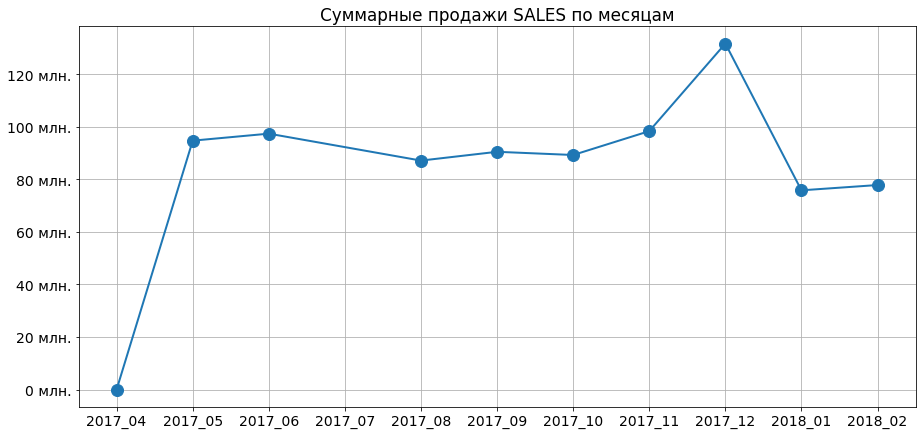

In [27]:
data['YEAR_MONTH'] = data["YEAR"].astype('str') + '_' \
                     + data["MONTH"].astype('str').apply(lambda x: x.zfill(2))
    
data.sort_values('YEAR_MONTH', inplace=True)

y = data.groupby('YEAR_MONTH')['SALES'].sum()
x = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
x_inds = list(y.index)
x_inds.append('2017_07')
x_inds.sort()
y_inds = [str(x)+' млн.' for x in range(0, 140, 20)]

plt.plot(x, y, marker='o', linewidth=2, markersize=12)
plt.xticks(range(11), x_inds)
plt.yticks([x*1e6 for x in range(0, 140, 20)], y_inds)
plt.grid(True)
plt.title('Суммарные продажи SALES по месяцам');

Узнаем как много нулевых и отрицательных значений по продажам. Возможно отрицательные несут какой-то физический смысл (разбитые партии, ошибки). Нулевых значений SALES 38%.

In [28]:
print('Нулевых значений SALES {:.2f}%'.format(100*data[data.SALES == 0].shape[0]/len(data)))
print('Отрицательных значений SALES {:.2f}%'.format(100*data[data.SALES < 0].shape[0]/len(data)))
data[data.SALES < 0]

Нулевых значений SALES 38.23%
Отрицательных значений SALES 0.04%


,YEAR,MONTH,CONTRAGENT,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,YEAR_MONTH
14210,2017,5,PRESTIGE BEVERAGE GROUP OF MD LLC,CATOCTIN CREEK MOSBYS SPIRIT - 750ML,LIQUOR,-1000,0,2017_05
13835,2017,5,PARK STREET IMPORTS LLC,TANTEO CHIPOTLE TEQUILA - 750ML,LIQUOR,-1000,0,2017_05
12637,2017,5,MHW LTD,BOL'S CREME DE MINT WHITE - 750ML,LIQUOR,-80,0,2017_05
7636,2017,5,CAMPARI AMERICA LLC,GRAND MARNIER 1880 - 750ML,LIQUOR,-160,0,2017_05
8528,2017,5,DELICATO FAMILY VINEYARDS,MASSIMO NEW ZELAND S/BLC - 750ML,WINE,-80,0,2017_05
6755,2017,5,BACCHUS IMPORTERS LTD,DOM CICCIO AND FIGLI FINOCCHIETO - 750ML,LIQUOR,-170,0,2017_05
6718,2017,5,BACCHUS IMPORTERS LTD,CLEAR CREEK S/M WHISKEY - 750ML,LIQUOR,-80,0,2017_05
26397,2017,6,MHW LTD,FEUDI D'ALBE MONTEPUL D'ABRU - 750ML,WINE,-770,15,2017_06
30571,2017,6,SOUTHERN GLAZERS WINE AND SPIRITS,LEGENDE BORDEAUX RG - 750ML,WINE,-430,0,2017_06
28991,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,BRANCOTT MARL P/NOIR - 750ML,WINE,-250,0,2017_06


In [29]:
print('Нулевых значений STORE_SALES {:.2f}%'.format(100*data[data.STORE_SALES == 0].shape[0]/len(data)))
print('Отрицательных значений STORE_SALES {:.2}%'.format(100*data[data.STORE_SALES < 0].shape[0]/len(data)))
data[data.STORE_SALES < 0]

Нулевых значений STORE_SALES 38.67%
Отрицательных значений STORE_SALES 0.18%


,YEAR,MONTH,CONTRAGENT,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,YEAR_MONTH
15020,2017,5,RELIABLE CHURCHILL LLLP,ROCA PATRON TEQUILA - SILVER - 750ML,LIQUOR,3210,-1,2017_05
14811,2017,5,RED INK IMPORTS,DEDICATO EX/DRY PROSECCO - 750ML,WINE,0,-1,2017_05
12415,2017,5,LEGENDS LTD,SOUTHERN TIER 3 CITRUS PEEL OUT - 6/4 12.OZ,BEER,0,-1,2017_05
12692,2017,5,MHW LTD,MASTI ITALIAN SAMBUCA - 1L,LIQUOR,8640,-1,2017_05
17153,2017,5,SOUTHERN GLAZERS WINE AND SPIRITS,TWO OCEANS SHZ 26936 - 750ML,WINE,0,-1,2017_05
...,...,...,...,...,...,...,...,...
115989,2018,2,ANHEUSER BUSCH INC,GOOSE ISLAND FEST BIER 1/2 KG,KEGS,0,-1,2018_02
120128,2018,2,FREDERICK P WINNER LTD,FULL TILT BALTIMORE PALE 1/2K,KEGS,0,-1,2018_02
121132,2018,2,KATCEF BROTHERS INC,SMUTTYNOSE VUNDERBAR PILS - 4/6NR 12.OZ,BEER,0,-3,2018_02
118964,2018,2,DOGFISH HEAD CRAFT BREWERY,DOGFISH HEAD HIGHER MATH 12OZ NR,BEER,1920,-1,2018_02


Посмотрим какие значения принимают категориальные признаки.

In [30]:
data.describe(include=['object'])

,CONTRAGENT,ARTICLE_NAME,ARTICLE_GROUP,YEAR_MONTH
count,128013,128013,128013,128013
unique,333,23413,7,10
top,REPUBLIC NATIONAL DISTRIBUTING CO,DONA PAULA LOS CARDOS MAL - 750ML,WINE,2017_11
freq,9820,17,78801,14495


In [31]:
print('Top-10 CONTRAGENT (наиболее часто встречаются в данных):')
100*data['CONTRAGENT'].value_counts(normalize=True, sort=True)[:10]

Top-10 CONTRAGENT (наиболее часто встречаются в данных):


REPUBLIC NATIONAL DISTRIBUTING CO    7.671096
A VINTNERS SELECTIONS                6.739940
LEGENDS LTD                          4.290970
SOUTHERN GLAZERS WINE AND SPIRITS    3.672283
E & J GALLO WINERY                   3.647286
BACCHUS IMPORTERS LTD                3.408248
MONSIEUR TOUTON SELECTION            3.312164
DIAGEO NORTH AMERICA INC             2.603642
RELIABLE CHURCHILL LLLP              2.231805
CONSTELLATION BRANDS                 2.227118
Name: CONTRAGENT, dtype: float64

In [32]:
print('Top-10 CONTRAGENT (по продажам):')
top_agents = data.groupby('CONTRAGENT')['SALES'].sum().sort_values(ascending=False)[:10]
top_agents 

Top-10 CONTRAGENT (по продажам):


CONTRAGENT
E & J GALLO WINERY          67455608
DIAGEO NORTH AMERICA INC    57656357
CONSTELLATION BRANDS        54472496
ANHEUSER BUSCH INC          42559140
JIM BEAM BRANDS CO          39156784
MILLER BREWING COMPANY      35022630
BACARDI USA INC             28034626
CROWN IMPORTS               26707830
SAZERAC CO                  25772623
THE WINE GROUP              25758147
Name: SALES, dtype: int64

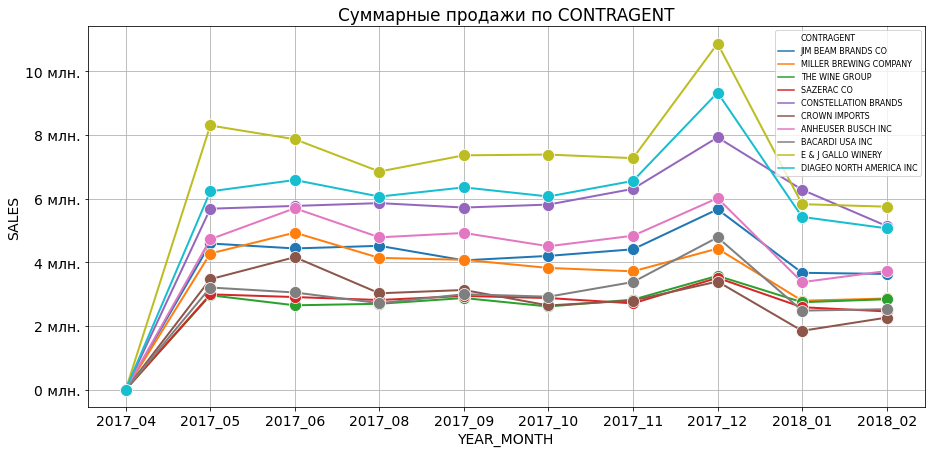

In [33]:
fig, ax = plt.subplots()
y_inds = [str(x)+' млн.' for x in range(0, 12, 2)]
sns.lineplot(x="YEAR_MONTH", y="SALES", hue="CONTRAGENT", 
             ci=None, estimator="sum", marker='o', linewidth=2, markersize=12,
             ax=ax, data=data[data['CONTRAGENT'].isin(top_agents.index)])
plt.yticks([x*1e6 for x in range(0, 12, 2)], y_inds)
plt.legend(fontsize=8)
plt.grid(True)
plt.title('Суммарные продажи по CONTRAGENT');

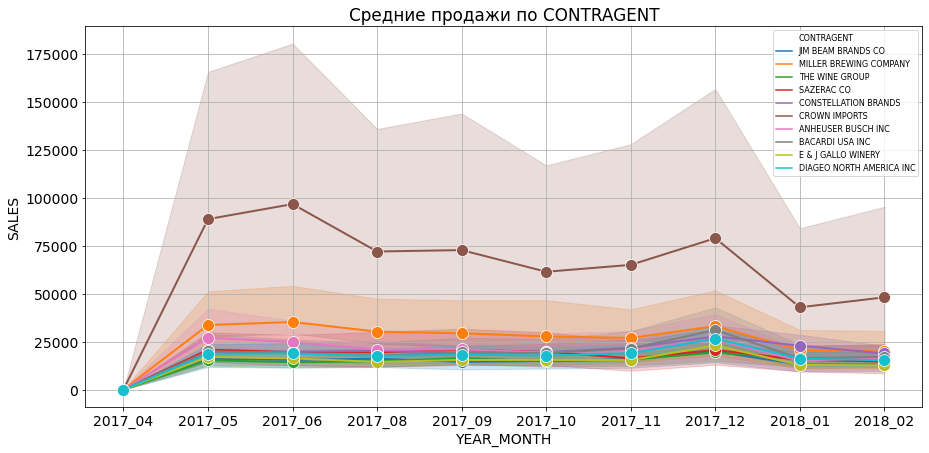

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x="YEAR_MONTH", y="SALES", hue="CONTRAGENT",  
             ci=95, estimator="mean", marker='o', linewidth=2, markersize=12,
             ax = ax, data=data[data['CONTRAGENT'].isin(top_agents.index)])
plt.legend(fontsize=8)
plt.grid(True)
plt.title('Средние продажи по CONTRAGENT');

Из графика видно, что у компании "CROWN IMPPORTS" большой разброс продаж.

In [35]:
data['ARTICLE_GROUP'].value_counts(normalize=True)

WINE            0.615570
LIQUOR          0.221720
BEER            0.128292
KEGS            0.028411
NON-ALCOHOL     0.004906
STR_SUPPLIES    0.000828
REF             0.000273
Name: ARTICLE_GROUP, dtype: float64

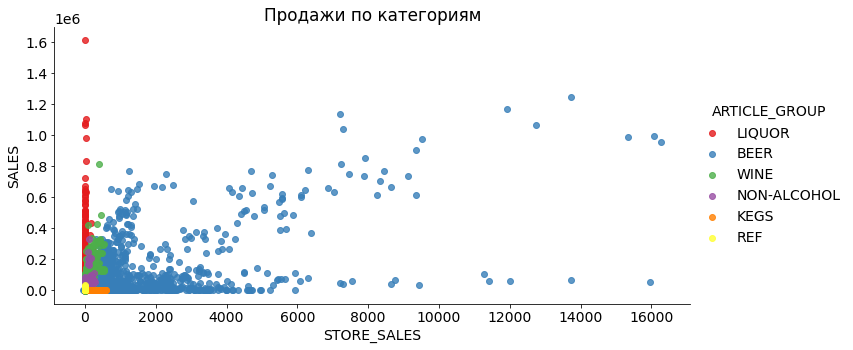

In [36]:
sns.lmplot('STORE_SALES', 'SALES', data=data, hue='ARTICLE_GROUP', 
           hue_order=['LIQUOR','BEER','WINE','NON-ALCOHOL','KEGS','REF'],
           palette="Set1", aspect=2, fit_reg=False)
plt.title('Продажи по категориям');

По графику видно, что продажи товаров различаются в зависимости от категорий: для BEER в среднем характерно большее значение STORE_SALES, в то время как для WINE и LIQUOR оно ближе к нулю. Для категорий KEGS, DUNNAGE, REF значения SALES близки к нулю и в среднем меньше чем для других категорий.

In [37]:
def conf_interval(vals):
    v_std = vals.std(ddof=1)/np.sqrt(len(vals))
    interval = _tconfint_generic(vals.mean(), v_std, len(vals) - 1, 0.05, 'two-sided')
    return [round(x,2) for x in interval]

data.groupby(['ARTICLE_GROUP'])['SALES','STORE_SALES'].agg([np.mean,
                    np.std, conf_interval]).sort_values(by=('SALES','mean'), ascending=False)

SALES                                     STORE_SALES  \
                       mean           std         conf_interval        mean   
ARTICLE_GROUP                                                                 
NON-ALCOHOL    12913.964968  28601.579886  [10672.68, 15155.25]   13.764331   
BEER           12772.520368  56836.382416   [11903.2, 13641.84]  148.355903   
LIQUOR         10916.668604  35949.534338  [10498.42, 11334.91]    1.166755   
STR_SUPPLIES    9396.037736  38724.369433   [1938.19, 16853.89]    0.000000   
REF             8038.285714   9573.052708   [4749.83, 11326.74]    0.000000   
WINE            3977.111090  13840.850732    [3880.47, 4073.75]    5.487215   
KEGS               0.000000      0.000000            [0.0, 0.0]   11.976354   

                                             
                      std     conf_interval  
ARTICLE_GROUP                                
NON-ALCOHOL     39.511392    [10.67, 16.86]  
BEER           646.936397  [138.46, 158.25]  
LIQUOR           7.787950      [1.08, 1.26]  
STR_SUPPLIES     0.000000        [0.0, 0.0]  
REF              0.000000        [0.0, 0.0]  
WINE            16.836309       [5.37, 5.6]  
KEGS            44.882152    [10.52, 13.44]

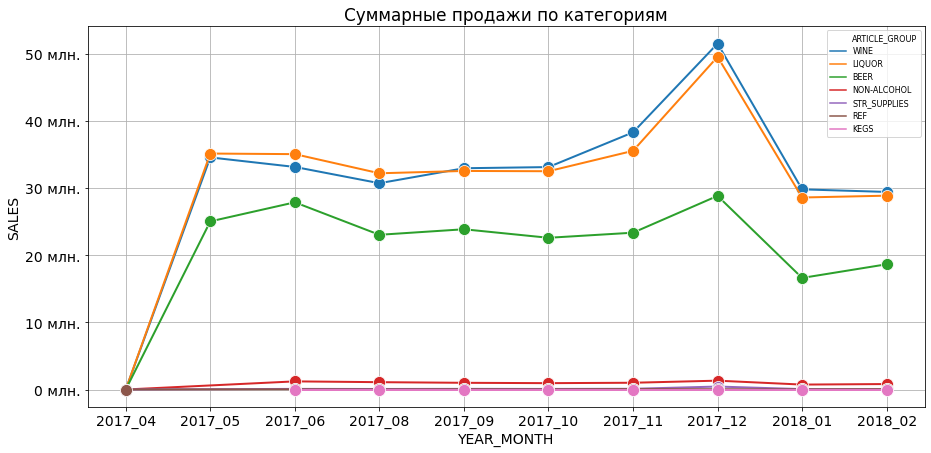

In [38]:
fig, ax = plt.subplots()
y_inds = [str(x)+' млн.' for x in range(0, 60, 10)]
sns.lineplot(x="YEAR_MONTH", y="SALES", hue="ARTICLE_GROUP", 
             ci=None, estimator="sum", marker='o', linewidth=2, markersize=12,
             ax=ax, data=data)
plt.yticks([x*1e6 for x in range(0, 60, 10)], y_inds)
plt.legend(fontsize=8)
plt.grid(True)
plt.title('Суммарные продажи по категориям');

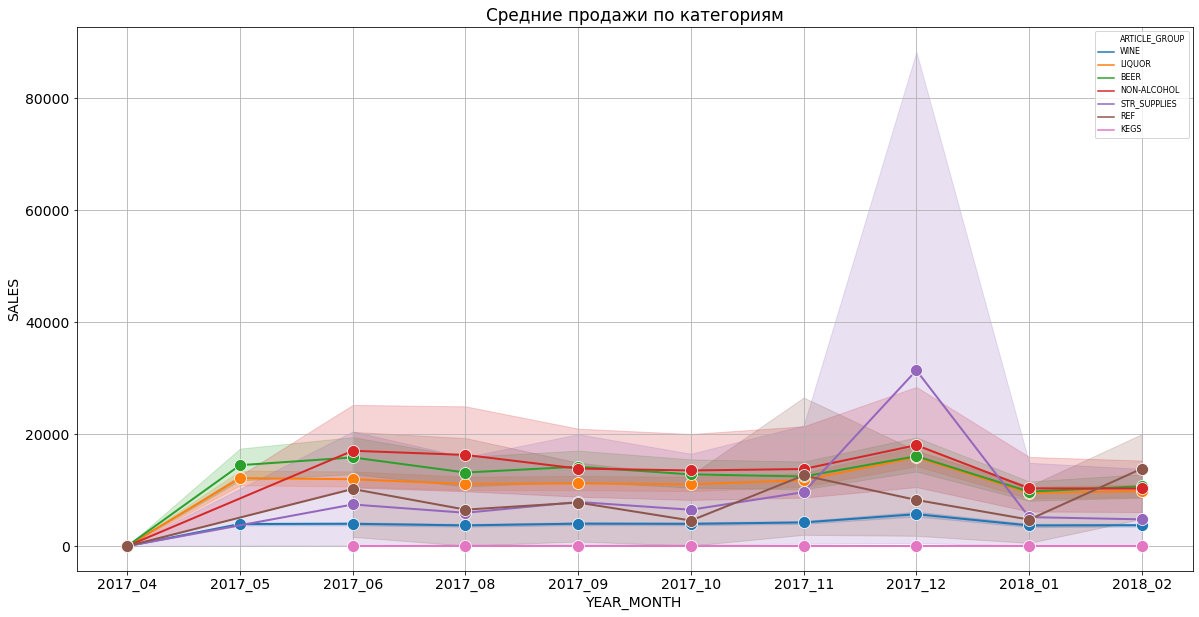

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x="YEAR_MONTH", y="SALES", hue="ARTICLE_GROUP",  
             ci=95, estimator="mean", marker='o', linewidth=2, markersize=12,
             ax = ax, data=data)
plt.legend(fontsize=8)
plt.grid(True)
plt.title('Средние продажи по категориям');

Top-10 ARTICLE_NAME (наиболее часто встречаются в данных):
DONA PAULA LOS CARDOS MAL - 750ML       17
SUN GARDEN RIES - 750ML                 13
LA CREMA CARNEROS P/NOIR - 750ML        12
ROSATELLO MOSCATO - 750ML               11
STORYPOINT CHARD  - 750ML               10
                                        ..
CH LYONNAT - 750ML                       1
DOM CROIX BELLE CHAMP DU LYS - 750ML     1
ST BERNARDUS ABT 12 NR 4/CS - 1.5L       1
MILLER HIGH LIFE LT 2/12 LNNR - 12OZ     1
LAMBERT EST SWEET JANE RIES - 750ML      1
Name: ARTICLE_NAME, Length: 23413, dtype: int64


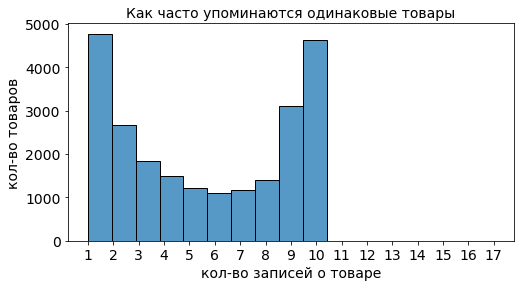

In [47]:
print('Top-10 ARTICLE_NAME (наиболее часто встречаются в данных):')
top_codes = data['ARTICLE_NAME'].value_counts(normalize=False, sort=True)
print(top_codes)
plt.figure(figsize = (8,4))
sns.histplot(top_codes, bins=17)
plt.title('Как часто упоминаются одинаковые товары', fontsize=14)
plt.xlabel('кол-во записей о товаре',fontsize=14)
plt.ylabel('кол-во товаров', fontsize=14)
plt.xticks(range(1,18),fontsize=14)
plt.yticks(fontsize=14);

Видим что даже для наиболее часто встречающихся в данных товаров число записей не больше 17. Посмотрим что за товары встречаются от 11 до 17 раз. Заметим, что частота их упоминаний больше чем количество месяцев (10) из-за того что их реализуют разные CONTRAGENT.

In [40]:
top_codes = data['ARTICLE_NAME'].value_counts(normalize=False, sort=True)
top_codes[top_codes > 10]

DONA PAULA LOS CARDOS MAL - 750ML    17
SUN GARDEN RIES - 750ML              13
LA CREMA CARNEROS P/NOIR - 750ML     12
ROSATELLO MOSCATO - 750ML            11
Name: ARTICLE_NAME, dtype: int64

In [41]:
data[data['ARTICLE_NAME'].isin(top_codes[top_codes > 10].index)
    ].sort_values(['ARTICLE_NAME','YEAR_MONTH'])[:20]

,YEAR,MONTH,CONTRAGENT,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,YEAR_MONTH
4638,2017,4,SUTTER HOME WINERY INC,DONA PAULA LOS CARDOS MAL - 750ML,WINE,0,0,2017_04
17385,2017,5,SUTTER HOME WINERY INC,DONA PAULA LOS CARDOS MAL - 750ML,WINE,820,18,2017_05
15465,2017,5,REPUBLIC NATIONAL DISTRIBUTING CO,DONA PAULA LOS CARDOS MAL - 750ML,WINE,1680,0,2017_05
30987,2017,6,SUTTER HOME WINERY INC,DONA PAULA LOS CARDOS MAL - 750ML,WINE,500,20,2017_06
29154,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,DONA PAULA LOS CARDOS MAL - 750ML,WINE,3930,0,2017_06
44563,2017,8,SUTTER HOME WINERY INC,DONA PAULA LOS CARDOS MAL - 750ML,WINE,2040,12,2017_08
42716,2017,8,REPUBLIC NATIONAL DISTRIBUTING CO,DONA PAULA LOS CARDOS MAL - 750ML,WINE,160,0,2017_08
57934,2017,9,SUTTER HOME WINERY INC,DONA PAULA LOS CARDOS MAL - 750ML,WINE,3500,7,2017_09
71507,2017,10,SUTTER HOME WINERY INC,DONA PAULA LOS CARDOS MAL - 750ML,WINE,1540,22,2017_10
69673,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,DONA PAULA LOS CARDOS MAL - 750ML,WINE,80,0,2017_10


In [47]:
top_sales = data.groupby('ARTICLE_NAME')['SALES'].sum().sort_values(ascending=False)
top_sales[:10]

ARTICLE_NAME
CORONA EXTRA LOOSE NR - 12OZ     8961000
TITO'S HANDMADE VODKA - 1.75L    8684550
CORONA EXTRA 4/6 NR - 12OZ       6473630
HEINEKEN LOOSE NR - 12OZ         6273000
STELLA ARTOIS 4/6 NR - 11.2OZ    5627500
BOWMAN'S VODKA - 1.75L           5240480
MILLER LITE 30PK CAN - 12OZ      5153000
HEINEKEN 4/6 NR - 12OZ           4994520
BLUE MOON 4/6 NR - 12OZ          4625690
YUENGLING LAGER 4/6 NR - 12OZ    4606840
Name: SALES, dtype: int64

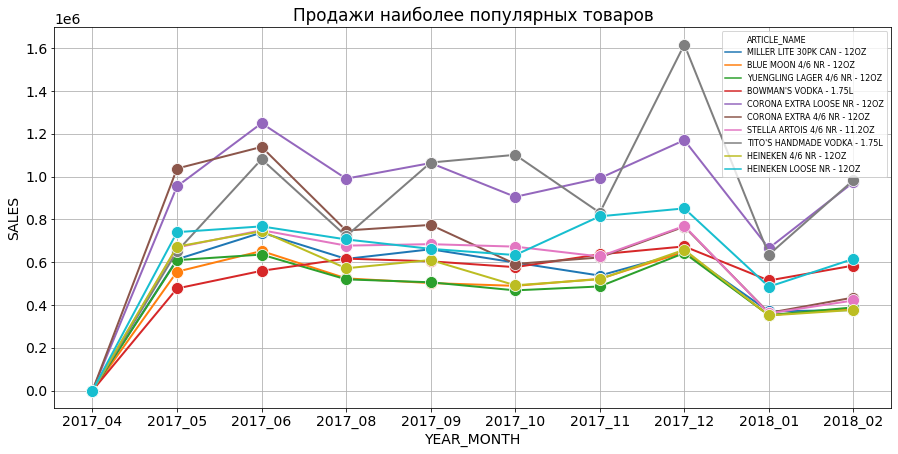

In [48]:
fig, ax = plt.subplots()
y_inds = [str(x)+' млн.' for x in range(0, 60, 10)]
sns.lineplot(x="YEAR_MONTH", y="SALES", hue="ARTICLE_NAME", 
             ci=None, estimator="mean", marker='o', linewidth=2, markersize=12,
             ax=ax, data=data[data['ARTICLE_NAME'].isin(top_sales[:10].index)])
plt.legend(fontsize=8)
plt.grid(True)
plt.title('Продажи наиболее популярных товаров');